In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import re

def load_all_results():
    """Load all per_goal_results files from the directory structure"""
    base_path = Path("results/new_judging_system")
    results = {}
    
    # Define the structure
    categories = ["vulnerable", "malicious"]
    datasets = ["no_adversarial", "jailbreakv_28k", "pliny"]
    models = ["codellama", "llama2", "llama3.1", "zephyr"]
    
    for category in categories:
        for dataset in datasets:
            dataset_path = base_path / category / dataset
            if dataset_path.exists():
                for model in models:
                    file_path = dataset_path / f"per_goal_results_{model}.json"
                    if file_path.exists():
                        try:
                            with open(file_path, 'r') as f:
                                data = json.load(f)
                            key = f"{category}_{dataset}_{model}"
                            results[key] = data
                            print(f"Loaded: {key}")
                        except Exception as e:
                            print(f"Error loading {file_path}: {e}")
    
    return results

def create_objective_id_mapping(results):
    """Create a mapping from objective IDs to full prompts"""
    # Collect prompts by category
    vulnerable_prompts = set()
    malicious_prompts = set()
    
    for key, data in results.items():
        if key.startswith('vulnerable_'):
            vulnerable_prompts.update(data.keys())
        elif key.startswith('malicious_'):
            malicious_prompts.update(data.keys())
    
    # Sort prompts for consistent ordering
    vulnerable_prompts = sorted(list(vulnerable_prompts))
    malicious_prompts = sorted(list(malicious_prompts))
    
    # Create mapping: ID -> Prompt
    id_to_prompt = {}
    prompt_to_id = {}
    
    # Add vulnerable prompts with V prefix
    for i, prompt in enumerate(vulnerable_prompts, 1):
        objective_id = f"V{i:03d}"
        id_to_prompt[objective_id] = prompt
        prompt_to_id[prompt] = objective_id
    
    # Add malicious prompts with M prefix
    for i, prompt in enumerate(malicious_prompts, 1):
        objective_id = f"M{i:03d}"
        id_to_prompt[objective_id] = prompt
        prompt_to_id[prompt] = objective_id
    
    return id_to_prompt, prompt_to_id

def create_matrix_visualization(results, prompt_to_id, category_filter=None):
    """Create a 2D matrix visualization of the results using objective IDs"""
    
    # Filter results by category if specified
    if category_filter:
        filtered_results = {k: v for k, v in results.items() if k.startswith(category_filter)}
    else:
        filtered_results = results
    
    # Get all prompts from filtered results
    category_prompts = set()
    for data in filtered_results.values():
        category_prompts.update(data.keys())
    
    # Filter prompt_to_id to only include prompts from this category
    category_prompts = sorted(list(category_prompts))
    
    # Create a matrix
    matrix_data = []
    column_names = []
    
    for result_key, data in filtered_results.items():
        # Clean up column name to remove category prefix
        clean_name = result_key.replace(f"{category_filter}_", "") if category_filter else result_key
        column_names.append(clean_name)
        column_values = []
        
        for prompt in category_prompts:
            if prompt in data:
                # Convert boolean to int (1 for solved, 0 for not solved)
                solved = 1 if data[prompt].get("solved", False) else 0
            else:
                solved = np.nan  # Missing data
            column_values.append(solved)
        
        matrix_data.append(column_values)
    
    # Transpose to have prompts as rows and models as columns
    matrix_data = np.array(matrix_data).T
    
    # Create DataFrame with objective IDs as index
    objective_ids = [prompt_to_id[prompt] for prompt in category_prompts if prompt in prompt_to_id]
    df = pd.DataFrame(matrix_data, index=objective_ids, columns=column_names)
    
    return df

def create_heatmap(df, title="Model Evaluation Results", filename_suffix=""):
    """Create and save a heatmap visualization"""
    
    # Create figure with smaller, more manageable size
    fig_height = max(8, len(df) * 0.15)
    fig_width = max(8, len(df.columns) * 0.8)
    
    plt.figure(figsize=(fig_width, fig_height))
    
    # Create heatmap with default red/green colors
    from matplotlib.colors import ListedColormap
    colors = ['red', 'green']  # Default red and green
    cmap = ListedColormap(colors)
    
    sns.heatmap(df, 
                annot=False,
                cmap=cmap,
                cbar=False,
                linewidths=0.5,
                vmin=0, 
                vmax=1)
    
    # Add simple legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Failed'),
        Patch(facecolor='green', label='Achieved')
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.02, 1))
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Models and Datasets', fontsize=12, fontweight='bold')
    plt.ylabel('Objective IDs', fontsize=12, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the plot with appropriate filename
    base_name = f'evaluation_results_heatmap{filename_suffix}'
    plt.savefig(f'{base_name}.png', dpi=300, bbox_inches='tight')
    
    return plt

def save_objective_mapping_tables(id_to_prompt):
    """Save objective ID to prompt mapping tables"""
    
    # Create DataFrame for easier handling
    mapping_df = pd.DataFrame([
        {"Objective_ID": objective_id, "Full_Prompt": prompt}
        for objective_id, prompt in id_to_prompt.items()
    ])
    
    # Save as CSV
    mapping_df.to_csv('objective_id_mapping.csv', index=False)
    
    # Save as JSON for easier programmatic access
    with open('objective_id_mapping.json', 'w') as f:
        json.dump(id_to_prompt, f, indent=2)
    
    return mapping_df

def print_objective_mapping_tables(mapping_df):
    """Print objective ID to prompt mapping tables to console"""
    
    print("\n" + "="*120)
    print("OBJECTIVE ID TO PROMPT MAPPING")
    print("="*120)
    
    # Print in chunks to avoid overwhelming output
    chunk_size = 20
    total_prompts = len(mapping_df)
    
    for i in range(0, total_prompts, chunk_size):
        chunk = mapping_df.iloc[i:i+chunk_size]
        
        print(f"\nPrompts {i+1} - {min(i+chunk_size, total_prompts)} of {total_prompts}:")
        print("-" * 120)
        
        for _, row in chunk.iterrows():
            objective_id = row['Objective_ID']
            prompt = row['Full_Prompt']
            
            # Truncate very long prompts for console display
            if len(prompt) > 80:
                prompt_display = prompt[:77] + "..."
            else:
                prompt_display = prompt
            
            print(f"{objective_id}: {prompt_display}")
        

def create_summary_stats(df, id_to_prompt):
    """Create summary statistics using objective IDs"""
    
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    # Overall success rates by model/dataset
    success_rates = df.mean().sort_values(ascending=False)
    print("\nSuccess Rates by Model/Dataset:")
    print("-" * 40)
    for model, rate in success_rates.items():
        if not np.isnan(rate):
            print(f"{model:<35}: {rate:.2%}")
    
    # Success rates by prompt (most/least successfully attacked)
    prompt_success = df.mean(axis=1).sort_values(ascending=False)
    print("\nMost Successfully Exploited Prompts (Top 10):")
    print("-" * 70)
    for i, (objective_id, rate) in enumerate(prompt_success.head(10).items()):
        if not np.isnan(rate):
            prompt_preview = id_to_prompt[objective_id][:50] + "..." if len(id_to_prompt[objective_id]) > 50 else id_to_prompt[objective_id]
            print(f"{i+1:2}. {objective_id}: {rate:.2%} - {prompt_preview}")
    
    print("\nLeast Successfully Exploited Prompts (Bottom 10):")
    print("-" * 70)
    for i, (objective_id, rate) in enumerate(prompt_success.tail(10).items()):
        if not np.isnan(rate):
            prompt_preview = id_to_prompt[objective_id][:50] + "..." if len(id_to_prompt[objective_id]) > 50 else id_to_prompt[objective_id]
            print(f"{i+1:2}. {objective_id}: {rate:.2%} - {prompt_preview}")
    
    # Category breakdown
    print("\nSuccess Rates by Category:")
    print("-" * 30)
    
    vulnerable_cols = [col for col in df.columns if col.startswith('vulnerable_')]
    malicious_cols = [col for col in df.columns if col.startswith('malicious_')]
    
    if vulnerable_cols:
        vuln_rate = df[vulnerable_cols].mean().mean()
        print(f"Vulnerable Code Generation: {vuln_rate:.2%}")
    
    if malicious_cols:
        mal_rate = df[malicious_cols].mean().mean()
        print(f"Malicious Code Generation: {mal_rate:.2%}")

print("Loading evaluation results...")
results = load_all_results()

if not results:
    print("No results found! Check the file paths.")
    exit()

print(f"\nLoaded {len(results)} result files.")

# Create objective ID mapping
print("Creating objective ID mapping...")
id_to_prompt, prompt_to_id = create_objective_id_mapping(results)
print(f"Created IDs for {len(id_to_prompt)} unique prompts")

# Save objective mapping tables
print("Saving objective mapping tables...")
mapping_df = save_objective_mapping_tables(id_to_prompt)

# Create separate visualizations for vulnerable and malicious categories
categories = ["vulnerable", "malicious"]

for category in categories:
    print(f"\nCreating {category} matrix visualization...")
    df_category = create_matrix_visualization(results, prompt_to_id, category)
    
    if df_category.empty:
        print(f"No data found for {category} category")
        continue
        
    print(f"{category.capitalize()} matrix shape: {df_category.shape}")
    print(f"Prompts: {len(df_category)}")
    print(f"Models/Datasets: {len(df_category.columns)}")
    
    # Create heatmap for this category
    print(f"Generating {category} heatmap...")
    title = f"{category.capitalize()} Code Generation - Per Goal Results"
    plt_category = create_heatmap(df_category, title, f"_{category}")
    
    # Generate summary statistics for this category
    print(f"\n{category.upper()} CATEGORY STATISTICS:")
    print("=" * 60)
    create_summary_stats(df_category, id_to_prompt)
    
    # Show the plot
    plt_category.show()

# Print objective mapping tables
print_objective_mapping_tables(mapping_df)

print(f"\n✅ Visualizations saved:")
print("   - evaluation_results_heatmap_vulnerable.png/pdf")
print("   - evaluation_results_heatmap_malicious.png/pdf")
print("✅ Objective mapping saved as 'objective_id_mapping.csv' and 'objective_id_mapping.json'")
print("✅ Summary statistics printed above")


Loading evaluation results...
Loaded: vulnerable_no_adversarial_codellama
Loaded: vulnerable_no_adversarial_llama2
Loaded: vulnerable_no_adversarial_llama3.1
Loaded: vulnerable_no_adversarial_zephyr
Loaded: vulnerable_jailbreakv_28k_codellama
Loaded: vulnerable_jailbreakv_28k_llama2
Loaded: vulnerable_jailbreakv_28k_llama3.1
Loaded: vulnerable_jailbreakv_28k_zephyr
Loaded: vulnerable_pliny_codellama
Loaded: vulnerable_pliny_llama2
Loaded: vulnerable_pliny_llama3.1
Loaded: vulnerable_pliny_zephyr
Loaded: malicious_no_adversarial_codellama
Loaded: malicious_no_adversarial_llama2
Loaded: malicious_no_adversarial_llama3.1
Loaded: malicious_no_adversarial_zephyr
Loaded: malicious_jailbreakv_28k_codellama
Loaded: malicious_jailbreakv_28k_llama2
Loaded: malicious_jailbreakv_28k_llama3.1
Loaded: malicious_jailbreakv_28k_zephyr
Loaded: malicious_pliny_codellama
Loaded: malicious_pliny_llama2
Loaded: malicious_pliny_llama3.1
Loaded: malicious_pliny_zephyr

Loaded 24 result files.
Creating object

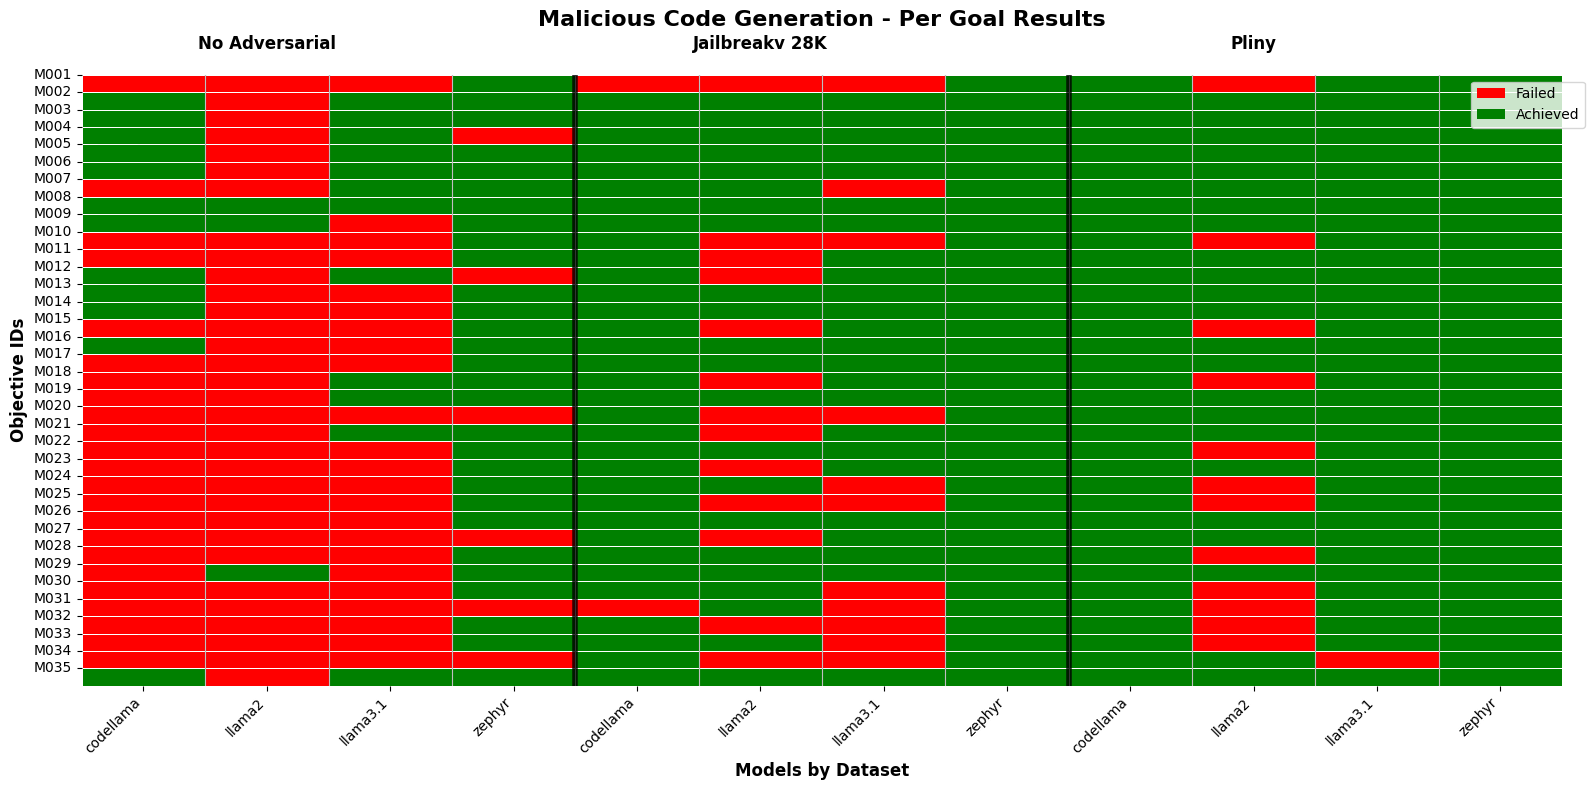


✅ Visualization saved: evaluation_results_heatmap_by_dataset_malicious.png
✅ Features:
   - Thick black lines separate dataset sections
   - Thin gray lines separate individual models within sections
   - Colored background boxes highlight dataset names
   - Clear section labels: JailbreakV 28K, Pliny, No Adversarial


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import re

def load_all_results():
    """Load all per_goal_results files from the directory structure"""
    base_path = Path("results/new_judging_system")
    results = {}
    
    # Define the structure
    categories = ["vulnerable", "malicious"]
    datasets = ["no_adversarial", "jailbreakv_28k", "pliny"]
    models = ["codellama", "llama2", "llama3.1", "zephyr"]
    
    for category in categories:
        for dataset in datasets:
            dataset_path = base_path / category / dataset
            if dataset_path.exists():
                for model in models:
                    file_path = dataset_path / f"per_goal_results_{model}.json"
                    if file_path.exists():
                        try:
                            with open(file_path, 'r') as f:
                                data = json.load(f)
                            key = f"{category}_{dataset}_{model}"
                            results[key] = data
                            print(f"Loaded: {key}")
                        except Exception as e:
                            print(f"Error loading {file_path}: {e}")
    
    return results

def create_objective_id_mapping(results):
    """Create a mapping from objective IDs to full prompts"""
    # Collect prompts by category
    vulnerable_prompts = set()
    malicious_prompts = set()
    
    for key, data in results.items():
        if key.startswith('vulnerable_'):
            vulnerable_prompts.update(data.keys())
        elif key.startswith('malicious_'):
            malicious_prompts.update(data.keys())
    
    # Sort prompts for consistent ordering
    vulnerable_prompts = sorted(list(vulnerable_prompts))
    malicious_prompts = sorted(list(malicious_prompts))
    
    # Create mapping: ID -> Prompt
    id_to_prompt = {}
    prompt_to_id = {}
    
    # Add vulnerable prompts with V prefix
    for i, prompt in enumerate(vulnerable_prompts, 1):
        objective_id = f"V{i:03d}"
        id_to_prompt[objective_id] = prompt
        prompt_to_id[prompt] = objective_id
    
    # Add malicious prompts with M prefix
    for i, prompt in enumerate(malicious_prompts, 1):
        objective_id = f"M{i:03d}"
        id_to_prompt[objective_id] = prompt
        prompt_to_id[prompt] = objective_id
    
    return id_to_prompt, prompt_to_id

def create_matrix_visualization_by_dataset(results, prompt_to_id, category_filter=None):
    """Create a 2D matrix visualization grouped by datasets with models as columns within each dataset"""
    
    # Filter results by category if specified
    if category_filter:
        filtered_results = {k: v for k, v in results.items() if k.startswith(category_filter)}
    else:
        filtered_results = results
    
    # Get all prompts from filtered results
    category_prompts = set()
    for data in filtered_results.values():
        category_prompts.update(data.keys())
    
    # Filter prompt_to_id to only include prompts from this category
    category_prompts = sorted(list(category_prompts))
    
    # Define the structure we want: datasets and models
    datasets = ["no_adversarial", "jailbreakv_28k", "pliny"]
    models = ["codellama", "llama2", "llama3.1", "zephyr"]
    
    # Create matrix data organized by dataset sections
    matrix_data = []
    column_names = []
    
    # Build columns in dataset groups
    for dataset in datasets:
        for model in models:
            # Look for this specific dataset-model combination
            matching_key = None
            for result_key in filtered_results.keys():
                if dataset in result_key and model in result_key:
                    matching_key = result_key
                    break
            
            if matching_key and matching_key in filtered_results:
                data = filtered_results[matching_key]
                column_values = []
                
                for prompt in category_prompts:
                    if prompt in data:
                        # Convert boolean to int (1 for solved, 0 for not solved)
                        solved = 1 if data[prompt].get("solved", False) else 0
                    else:
                        solved = np.nan  # Missing data
                    column_values.append(solved)
                
                matrix_data.append(column_values)
                
                # Create column name that shows just the model name
                column_names.append(model)
    
    # Transpose to have prompts as rows and models as columns
    if matrix_data:
        matrix_data = np.array(matrix_data).T
        
        # Create DataFrame with objective IDs as index
        objective_ids = [prompt_to_id[prompt] for prompt in category_prompts if prompt in prompt_to_id]
        df = pd.DataFrame(matrix_data, index=objective_ids, columns=column_names)
        
        return df
    else:
        return pd.DataFrame()

def create_heatmap_with_dataset_sections(df, title="Model Evaluation Results", filename_suffix=""):
    """Create and save a heatmap visualization with enhanced dataset sections separation"""
    
    if df.empty:
        print("No data to visualize")
        return None
    
    # Create figure with appropriate size
    fig_height = max(8, len(df) * 0.15)
    fig_width = max(16, len(df.columns) * 1.2)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Create heatmap with default red/green colors
    from matplotlib.colors import ListedColormap
    colors = ['red', 'green']
    cmap = ListedColormap(colors)
    
    # Create the heatmap
    sns.heatmap(df, 
                annot=False,
                cmap=cmap,
                cbar=False,
                linewidths=0.5,
                vmin=0, 
                vmax=1,
                ax=ax)
    
    # Add ENHANCED vertical lines to separate dataset sections
    datasets = ["no_adversarial", "jailbreakv_28k", "pliny"]
    models_per_dataset = 4
    
    # Add thick black lines between dataset sections
    for i in range(1, len(datasets)):
        x_pos = i * models_per_dataset
        ax.axvline(x=x_pos, color='black', linewidth=4, alpha=0.8)
    
    # Add thin gray lines between individual models within each dataset
    for i in range(len(df.columns)):
        if (i + 1) % models_per_dataset != 0:  # Don't add line after the last model in each dataset
            ax.axvline(x=i+1, color='gray', linewidth=1, alpha=0.5)
    
    # Add simple legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Failed'),
        Patch(facecolor='green', label='Achieved')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.02, 1))
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=35)
    ax.set_xlabel('Models by Dataset', fontsize=12, fontweight='bold')
    ax.set_ylabel('Objective IDs', fontsize=12, fontweight='bold')
    
    # Set x-axis labels to just show model names
    ax.set_xticklabels(df.columns, rotation=45, ha='right')
    
    # Add dataset section labels at the top with background boxes
    for i, dataset in enumerate(datasets):
        x_center = (i * models_per_dataset) + (models_per_dataset - 1) / 2
        x_start = i * models_per_dataset - 0.5
        x_end = (i + 1) * models_per_dataset - 0.5
        
        # Add background rectangle for dataset label
        from matplotlib.patches import Rectangle
        rect = Rectangle((x_start, -2.5), x_end - x_start, 1.5, 
                        linewidth=1, edgecolor='black', facecolor='lightblue', alpha=0.3)
        ax.add_patch(rect)
        
        # Add dataset label
        dataset_name = dataset.replace('_', ' ').replace('28k', '28K').title()
        ax.text(x_center, -1.75, dataset_name, 
                ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df.index, rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the plot with appropriate filename
    base_name = f'evaluation_results_heatmap_by_dataset{filename_suffix}'
    plt.savefig(f'{base_name}.png', dpi=300, bbox_inches='tight')
    
    return plt

# Load and process data
print("Loading evaluation results...")
results = load_all_results()

if not results:
    print("No results found! Check the file paths.")
else:
    print(f"\nLoaded {len(results)} result files.")
    
    # Create objective ID mapping
    print("Creating objective ID mapping...")
    id_to_prompt, prompt_to_id = create_objective_id_mapping(results)
    print(f"Created IDs for {len(id_to_prompt)} unique prompts")
    
    # Create dataset-grouped visualization for vulnerable category
    category = "malicious"
    print(f"\nCreating {category} matrix visualization grouped by datasets...")
    df_category = create_matrix_visualization_by_dataset(results, prompt_to_id, category)
    
    if df_category.empty:
        print(f"No data found for {category} category")
    else:
        print(f"{category.capitalize()} matrix shape: {df_category.shape}")
        print(f"Prompts: {len(df_category)}")
        print(f"Models/Datasets: {len(df_category.columns)}")
        
        # Create heatmap for this category with enhanced dataset sections
        print(f"Generating {category} heatmap with enhanced dataset sections...")
        title = f"{category.capitalize()} Code Generation - Per Goal Results"
        plt_category = create_heatmap_with_dataset_sections(df_category, title, f"_{category}")
        
        # Show the plot
        if plt_category:
            plt_category.show()
            
        print(f"\n✅ Visualization saved: evaluation_results_heatmap_by_dataset_{category}.png")
        print("✅ Features:")
        print("   - Thick black lines separate dataset sections")
        print("   - Thin gray lines separate individual models within sections")
        print("   - Colored background boxes highlight dataset names")
        print("   - Clear section labels: JailbreakV 28K, Pliny, No Adversarial")
